This notebook constructs a simple model of evolving state number densities for a single mass bin.  The method is tested by simulating some data and fitting it, recovering the correct parameters.  The fit may be performed using direct minimization, or MCMC in order to explore the parameter space.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image

In [2]:
# Steven's emcee stuff
from convenience import run_emcee
from pdfs import norm_logpdf, beta_logpdf
import plots

In [3]:
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

In [4]:
C = cosmology.FlatLambdaCDM(70.0, 0.3)

In [5]:
states = pd.Index(('BD', 'RD', 'RE'))
nStates = len(states)

In [6]:
rate_labels = [['$r_{' + '{} \\rightarrow {}'.format(s2, s1) + '}$' for s2 in states] for s1 in states]
rate_labels = pd.DataFrame(index='to ' + states, columns='from ' + states, data=rate_labels)
rate_evol_labels = rate_labels.replace('\$r', '$\dot{r}', regex=True)
N_labels = '$N_{' + states + '}$'

In [7]:
N_labels

Index(['$N_{BD}$', '$N_{RD}$', '$N_{RE}$'], dtype='object')

In [8]:
rate_labels

,from BD,from RD,from RE
to BD,$r_{BD \rightarrow BD}$,$r_{RD \rightarrow BD}$,$r_{RE \rightarrow BD}$
to RD,$r_{BD \rightarrow RD}$,$r_{RD \rightarrow RD}$,$r_{RE \rightarrow RD}$
to RE,$r_{BD \rightarrow RE}$,$r_{RD \rightarrow RE}$,$r_{RE \rightarrow RE}$


In [9]:
rate_evol_labels

,from BD,from RD,from RE
to BD,$\dot{r}_{BD \rightarrow BD}$,$\dot{r}_{RD \rightarrow BD}$,$\dot{r}_{RE \rightarrow BD}$
to RD,$\dot{r}_{BD \rightarrow RD}$,$\dot{r}_{RD \rightarrow RD}$,$\dot{r}_{RE \rightarrow RD}$
to RE,$\dot{r}_{BD \rightarrow RE}$,$\dot{r}_{RD \rightarrow RE}$,$\dot{r}_{RE \rightarrow RE}$


Basic differential equations:

$\frac{dN_{BD}}{dt} = - N_{BD} \, (r_{BD \rightarrow RD} + r_{BD \rightarrow RE})$

$\frac{dN_{RD}}{dt} = - N_{RD} \, r_{RD \rightarrow RE} + N_{BD} \, r_{BD \rightarrow RD}$

$\frac{dN_{RE}}{dt} = + N_{BD} \, r_{BD \rightarrow RE} + N_{RD} \, r_{RD \rightarrow RE}$

In [10]:
# Set rates per galaxy in Gyr^{-1} at fiducial redshift
rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((nStates, nStates)))
rates['from BD']['to RD'] = 0.05
rates['from RD']['to RE'] = 0.05
rates['from BD']['to RE'] = 0.01
for s in states:
    rates['from ' + s]['to ' + s] = 0
    rates['from ' + s]['to ' + s] = - rates['from ' + s].sum()
rates

,from BD,from RD,from RE
to BD,-0.06,0.00,0.0
to RD,0.05,-0.05,0.0
to RE,0.01,0.05,-0.0


In [11]:
# Modelling rates as linear function of cosmic time
#(for simplicity, should probably choose someting more appropriate)
rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((nStates, nStates)))
rates_evol['from BD']['to RD'] = 0.01  # comment out this to have no evolution!

In [12]:
def rates_function(rates, rates_evol, t, t0):
    rates = rates + rates_evol * (t - t0)
    # * For a closed model the columns of the rates matrix must sum to zero
    #   so there is no creation/destruction of galaxies, this is enforced here.
    # * Creation/destruction of galaxies basically means they move in to or
    #   out of the sample given the selection criteria.
    # * Another possibility is merging, where one galaxies is 'destroyed' in
    #   each merger.
    # * If one wishes to create/destroy galaxies then that could perhaps
    #   be achieved by allowing rates to not sum to zero in each column.
    #   However, the total numbers of galaxies moving between states are
    #   proportional to the number currently in the initial state, which
    #   probably doesn't make much sense for creation.
    #   Alternatively, one could add an additional state(s) representing the pool(s)
    #   from which galaxies are created/destroyed (but this would be evolved itself).
    #   Or one could add additional terms in the differential equation to
    #   describe the creation/destruction of galaxies.
    # * Another issue is multiple selection criteria, e.g. mass bins.
    #   These are essentially different states, and we can model transitions
    #   between them in the same manner: in a small time a galaxy in a given state
    #   will have a particular (potentially time dependent) probability of moving
    #   from one mass bin to the next
    #   (proportional to [SFR + merger accretion rate] / mass_bin_width).
    # * In principle, the rates related to the destruction of galaxies in particular
    #   states due to merging and the mass growth of the merger remnant are related.
    #   In practise this would be pretty complex to manage unless we make some
    #   strict assumptions.  For example, we could assume that only galaxies in the
    #   same state merge (hence ~doubling their mass) and thus require the
    #   destruction rate to be proportional to the mass bin transition rate
    #   (where the factor depends on the width of the mass bin).
    #   If we get too complicated, then it would make more sense to simulate a large
    #   population of individual galaxies rather than consider a small set of states.
    for s in states:
        rates.loc['to ' + s, 'from ' + s] = 0
        rates.loc['to ' + s, 'from ' + s] = - rates['from ' + s].sum()
    return rates

In [13]:
# test it out...
rates_function(rates, rates_evol, t=C.age(0.3).value, t0=C.age(1.0).value)

,from BD,from RD,from RE
to BD,-0.102965,0.00,0.0
to RD,0.092965,-0.05,0.0
to RE,0.010000,0.05,-0.0


In [14]:
def model(N, t, ratefn, rates, rates_evol, t0):
    rates = ratefn(rates, rates_evol, t, t0)
    return np.dot(rates, N)

In [15]:
# initial relative number densities
# for log(M*/Msun) ~ 10.5, starting with f_{R|D} ~ 0.05 and f_{D|R} ~ 0.1 at z ~ 1
N0 = pd.Series(index='$N_{' + states + '}$', data=[0.6, 0.03, 0.3])
N0 /= N0.sum()  # normalise to unity
N0

$N_{BD}$    0.645161
$N_{RD}$    0.032258
$N_{RE}$    0.322581
dtype: float64

In [16]:
# redshifts and times to evaluate
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value

In [17]:
N = odeint(model, N0, t, args=(rates_function, rates, rates_evol, t0))

In [18]:
N = pd.DataFrame(index=z, columns='$N_{' + states + '}$', data=N)
N = N[::-1]

In [19]:
F = pd.DataFrame(index=N.index)
F['$f_{R|D}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{BD}$'])
F['$f_{D|R}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{RE}$'])

In [20]:
def plot_NF(N, F):
    fig, (axN, axF) = plt.subplots(1, 2, figsize=(12, 6))
    N.plot(ax=axN)
    axN.set(xlabel='$z$', ylabel='$N(z)/N(z={:.1f})$'.format(zstart), ylim=(0, 1));
    F.plot(ax=axF)
    axF.set(xlabel='$z$', ylabel='$f(z)$', ylim=(0, 0.4));
    plt.tight_layout()

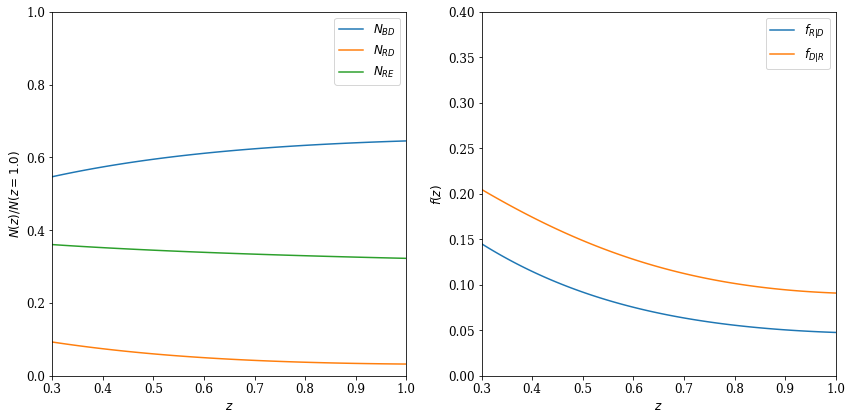

In [21]:
plot_NF(N, F)

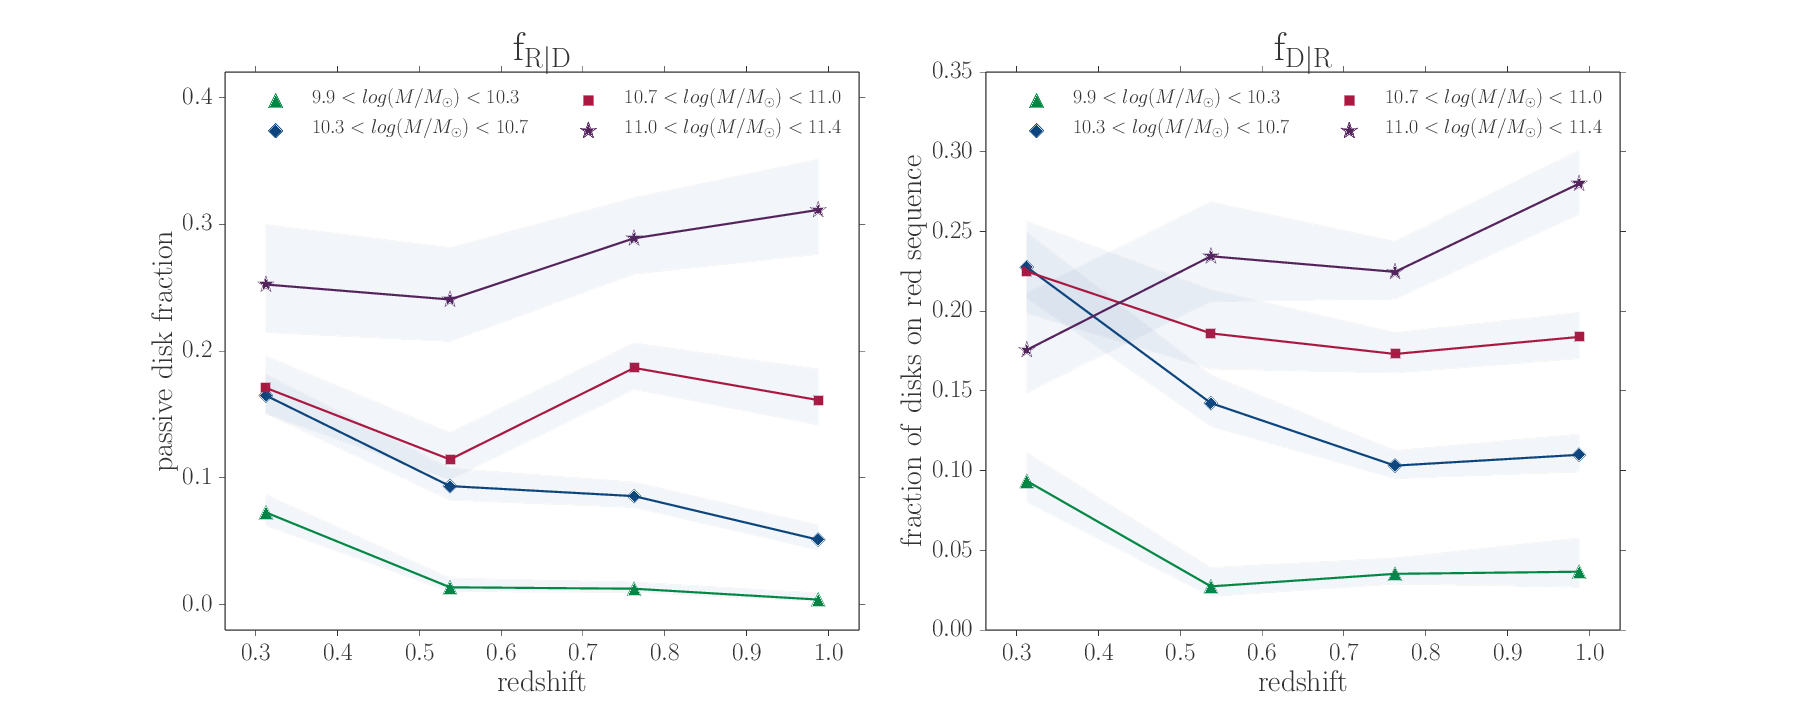

In [22]:
Image('red_disk_fraction.png')

In [23]:
# simulated data for now
zdata = np.linspace(1.0, 0.3, 4)
tdata = C.age(zdata)
t0 = C.age(1.0).value
# using N0, rates and rates_evol defined above
Ndata = odeint(model, N0, tdata, args=(rates_function, rates, rates_evol, t0))
Ndata = pd.DataFrame(index=zdata, columns='$N_{' + states + '}$', data=Ndata)
# simple errors
Nerr = Ndata * 0 + 0.01

In [24]:
Ndata

,$N_{BD}$,$N_{RD}$,$N_{RE}$
1.000000,0.645161,0.032258,0.322581
0.766667,0.602181,0.066064,0.331755
0.533333,0.540861,0.113256,0.345883
0.300000,0.454597,0.176822,0.368582


In [25]:
Nerr

,$N_{BD}$,$N_{RD}$,$N_{RE}$
1.000000,0.01,0.01,0.01
0.766667,0.01,0.01,0.01
0.533333,0.01,0.01,0.01
0.300000,0.01,0.01,0.01


In [ ]:
class logProbabilities:
    def __init__(self, fit_N0, fit_rates, fit_rates_evol,
                 Ndata, Nerr, tdata, ratefn, N0_init, rates_init, rates_evol_init,
                 t0, N_labels, rate_labels, rate_evol_labels):
        # a boolean matrix describing which rates and evolutions to fit
        self.fit_N0 = fit_N0.copy()
        self.fit_rates = fit_rates.copy()
        self.fit_rates_evol = fit_rates_evol.copy()
        self.nStates = len(fit_rates)
        self.nFitN0 = self.fit_N0.values.sum()
        self.nFitRates = self.fit_rates.values.sum()
        self.nFitRatesEvol = self.fit_rates_evol.values.sum()
        self.pars = []
        self.pars.extend(N_labels.values[self.fit_N0.values])
        self.pars.extend(rate_labels.values[self.fit_rates.values])
        self.pars.extend(rate_evol_labels.values[self.fit_rates_evol.values])
        self.pars = pd.DataFrame(self.pars, columns=['parameter'])
        self.nPar = self.nFitN0 + self.nFitRates + self.nFitRatesEvol
        # the measured number density, Ndata,
        # in each state at time, tdata,
        # with its error, Nerr
        self.Ndata = Ndata.copy()
        self.Nerr = Nerr.copy()        
        self.tdata = tdata.copy()
        # the current rate matrix is determined using ratefn
        # from N0, the number densities at t0; rates, the rates at t0; and rates_evol
        self.ratefn = ratefn
        self.N0 = N0_init.copy()
        self.rates = rates_init.copy()
        self.rates_evol = rates_evol_init.copy()
        self.t0 = t0

    def split_pars(self, p):
        start, end = (0, self.nFitN0)
        p_N0 = p[start:end]
        start, end = (end, end + self.nFitRates)
        p_rates = p[start:end]
        start, end = (end, end + self.nFitRatesEvol)
        p_rates_evol = p[start:end]
        return p_N0, p_rates, p_rates_evol
        
    def evaluate(self, t, p):
        # update the model quantities given the current parameters
        p_N0, p_rates, p_rates_evol = self.split_pars(p)
        self.N0.values[self.fit_N0.values] = p_N0
        self.rates.values[self.fit_rates.values] = p_rates
        self.rates_evol.values[self.fit_rates_evol.values] = p_rates_evol
        # compute N at each tdata, given current parameters
        N = odeint(model, self.N0, t,
                   args=(self.ratefn, self.rates, self.rates_evol, self.t0))
        return N
    
    def prior(self, inpars):
        inshape = inpars.shape
        inpars = inpars.reshape((-1, self.nPar))
        lnP = np.zeros(inpars.shape[0])
        for i, p in enumerate(inpars):
            p_N0, p_rates, p_rates_evol = self.split_pars(p)
            lnP[i] = stats.uniform(0, 1).logpdf(p_N0).sum()
            lnP[i] += stats.uniform(0, 1).logpdf(p_rates).sum()
            lnP[i] += norm_logpdf(p_rates_evol, 0, 0.1).sum()
        return lnP.reshape(inshape[:-1])
    
    def likelihood(self, inpars):
        inshape = inpars.shape
        inpars = inpars.reshape((-1, self.nPar))
        lnL = np.zeros(inpars.shape[0])
        for i, p in enumerate(inpars):
            N = self.evaluate(self.tdata, p)
            # calculate Likelihood of computed N given Ndata and Nerr
            lnL[i] = norm_logpdf(N, self.Ndata.values, self.Nerr.values).sum()
        return lnL.reshape(inshape[:-1])
    
    def posterior(self, inpars):
        lnL = self.likelihood(inpars)
        lnP = self.prior(inpars)
        return lnL + lnP
    
    def neg_posterior(self, inpars):
        return -self.posterior(inpars)
    
    def init_pars(self, shape):
        ip = np.zeros(shape + (self.nPar,))
        start, end = (0, self.nFitN0)
        ip[..., start:end] = stats.uniform.rvs(0, 1, size=shape + (self.nFitN0,))
        start, end = (end, end + self.nFitRates)
        ip[..., start:end] = stats.uniform.rvs(0, 1, size=shape + (self.nFitRates,))
        start, end = (end, end + self.nFitRatesEvol)
        ip[..., start:end] = stats.norm.rvs(0, 0.1, size=shape + (self.nFitRatesEvol,))
        return ip

In [27]:
fit_N0 = pd.Series(index='$N_{' + states + '}$', data=np.zeros(nStates, np.bool))
fit_rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                         data=np.zeros((nStates, nStates), np.bool))
fit_rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
                         data=np.zeros((nStates, nStates), np.bool))

# Select which parameters to fit.
fit_N0[:] = True
fit_rates['from BD']['to RD'] = True
fit_rates['from RD']['to RE'] = True
fit_rates['from BD']['to RE'] = True
fit_rates_evol['from BD']['to RD'] = True

In [28]:
fit_N0

$N_{BD}$    True
$N_{RD}$    True
$N_{RE}$    True
dtype: bool

In [29]:
fit_rates

,from BD,from RD,from RE
to BD,False,False,False
to RD,True,False,False
to RE,True,True,False


In [30]:
fit_rates_evol

,from BD,from RD,from RE
to BD,False,False,False
to RD,True,False,False
to RE,False,False,False


In [31]:
# Define initial values.
# Those to be fit will vary.
# The rest will be held fixed at their initial values.
N0_init = pd.Series(Ndata.iloc[0], name=False)
rates_init = pd.DataFrame(index='to ' + states, columns='from ' + states,
                          data=np.zeros((nStates, nStates)))
rates_evol_init = pd.DataFrame(index='to ' + states, columns='from ' + states,
                               data=np.zeros((nStates, nStates)))

In [32]:
N0_init

$N_{BD}$    0.645161
$N_{RD}$    0.032258
$N_{RE}$    0.322581
dtype: float64

In [33]:
rates_init

,from BD,from RD,from RE
to BD,0.0,0.0,0.0
to RD,0.0,0.0,0.0
to RE,0.0,0.0,0.0


In [34]:
rates_evol_init

,from BD,from RD,from RE
to BD,0.0,0.0,0.0
to RD,0.0,0.0,0.0
to RE,0.0,0.0,0.0


In [35]:
logProb = logProbabilities(fit_N0, fit_rates, fit_rates_evol, Ndata, Nerr, tdata,
                           rates_function, N0_init, rates_init, rates_evol_init,
                           t0, N_labels, rate_labels, rate_evol_labels)

In [36]:
logProb.pars

,parameter
0,$N_{BD}$
1,$N_{RD}$
2,$N_{RE}$
3,$r_{BD \rightarrow RD}$
4,$r_{BD \rightarrow RE}$
5,$r_{RD \rightarrow RE}$
6,$\dot{r}_{BD \rightarrow RD}$


In [37]:
logProb.init_pars((5,))

array([[ 0.31061734,  0.57282484,  0.99825205,  0.33257392,  0.57611857,
         0.44851099, -0.09212262],
       [ 0.67066914,  0.84370926,  0.77510018,  0.28898993,  0.1397586 ,
         0.62912669,  0.15722027],
       [ 0.56469245,  0.73046562,  0.14509534,  0.12311613,  0.73541619,
         0.92490729,  0.14843101],
       [ 0.72804274,  0.37916308,  0.12050571,  0.82069377,  0.81634017,
         0.39880475, -0.01424107],
       [ 0.99225338,  0.13362952,  0.22465064,  0.21559245,  0.65701326,
         0.13383429, -0.04953098]])

In [38]:
truth = [0.645161, 0.032258, 0.322581, 0.05, 0.01, 0.05, 0.01]

In [39]:
logProb.posterior(np.vstack((logProb.init_pars((5,)), truth)))

array([ -6647.44446252, -21244.33772772, -11687.27351197, -13551.17343623,
       -11029.94806574,     45.61342639])

In [40]:
logProb.posterior(np.array(truth))

45.613426389393346

In [41]:
result = scipy.optimize.minimize(logProb.neg_posterior, [0.6, 0.03, 0.3, 0.06, 0.02, 0.06, 0.00], tol=1e-2)
result

/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: -45.613452925153695
 hess_inv: array([[  6.85733189e-05,  -2.31643054e-05,  -2.17664790e-05,
          3.40340490e-05,   4.56480774e-05,  -1.85340990e-04,
         -2.83570835e-05],
       [ -2.31643054e-05,   6.89472742e-05,  -2.09395601e-05,
         -8.66908063e-05,   4.14016982e-05,  -1.63315317e-04,
          1.57725334e-05],
       [ -2.17664790e-05,  -2.09395601e-05,   6.58809296e-05,
          5.10857476e-05,  -9.09564019e-05,   3.50728313e-04,
          1.28936550e-05],
       [  3.40340490e-05,  -8.66908063e-05,   5.10857476e-05,
          2.95547570e-04,  -1.85791268e-04,   9.11407792e-04,
         -4.89407171e-05],
       [  4.56480774e-05,   4.14016982e-05,  -9.09564019e-05,
         -1.85791268e-04,   3.19099618e-04,  -1.57640107e-03,
         -5.85519081e-05],
       [ -1.85340990e-04,  -1.63315317e-04,   3.50728313e-04,
          9.11407792e-04,  -1.57640107e-03,   8.35472391e-03,
          3.18096456e-04],
       [ -2.83570835e-05,   1.57725334e-05,   1.2893

In [ ]:
sampler = run_emcee(logProb.likelihood, logProb.prior, logProb.init_pars,
                    ntemps=3, nwalkers=50, nsamples=1500,
                    minlogbeta=None, nupdates=100, threads=4,
                    outfilename='mel_sampler_sim', saveall=True)

Steps: 200 400 600 800 1000 1200 1400 1600

KeyboardInterrupt: 

In [ ]:
statistics = plots.print_emcee(sampler, logProb.pars['parameter'], nburn=750,
                          model=logProb.evaluate, x=tdata, y=Ndata, yerror=Nerr,
                          truths=truth, outfilename='mel_sim')

In [ ]:
fit_rates_evol['from RD']['to RE'] = True
fit_rates_evol['from BD']['to RE'] = True

In [ ]:
logProb = LogProbabilities(fit_N0, fit_rates, fit_rates_evol, Ndata, Nerr, tdata,
                           rates_function, N0_init, rates_init, rates_evol_init,
                           t0, N_labels, rate_labels, rate_evol_labels)

init_pars = InitPars([[0, 1]] * logProb.nPar)

In [ ]:
result_evol = scipy.optimize.minimize(logProb.neg_posterior, [0.6, 0.03, 0.3, 0.06, 0.02, 0.06, 0.0, 0.0, 0.0], tol=1e-2)
result_evol

In [ ]:
sampler = run_emcee(logProb.likelihood, logProb.prior, logProb.init_pars,
                    ntemps=3, nwalkers=50, nsamples=1500,
                    minlogbeta=None, nupdates=100, threads=4,
                    outfilename='mel_sim_evol', saveall=True)

In [ ]:
statistics = plots.print_emcee(sampler, logProb.pars['parameter'], nburn=750,
                          model=logProb.evaluate, x=tdata, y=Ndata, yerror=Nerr,
                          truths=truth+[0,0], outfilename='mel_sim_evol')